# Naive ngram approach

https://www.kaggle.com/alvations/n-gram-language-model-with-nltk - ngram lm  
https://www.kaggle.com/anshulrai/cudnnlstm-implementation-93-7-accuracy - amazon reviews loader and data

In [1]:
from tqdm.notebook import tqdm

ngram_size = 4
data_amount = 1000000000 # number of characters mb

# Load data

In [2]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet
import re
import os

In [3]:
train_file = bz2.BZ2File('data/amazonreviews/train.ft.txt.bz2')
train_file_lines = train_file.readlines(size=data_amount)

del train_file

train_file_lines = [x.decode('utf-8') for x in train_file_lines]


train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
 
                                                      
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        

del train_file_lines

gc.collect()
print(len(train_sentences))

2240017


# Fit. Predict.

In [4]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lmura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from nltk import word_tokenize, sent_tokenize

# This is slow, I know, wygd
tokenized_sentences = list(tqdm(map(word_tokenize, train_sentences), total=len(train_sentences)))

In [6]:
from nltk.lm.preprocessing import padded_everygram_pipeline
training_ngrams, padded_sentences = padded_everygram_pipeline(ngram_size, tokenized_sentences)

In [7]:
from nltk.lm import MLE
model = MLE(ngram_size)
model.fit(tqdm(training_ngrams, total=len(train_sentences)), padded_sentences)
print(model.vocab)


KeyboardInterrupt



# Generation

In [8]:
def make_continuation(model, text, length=20):
    seed = word_tokenize(text)
    output = ' '.join(seed + model.generate(length, text_seed=seed))
    output = output[:output.find('</s>')] if output.find('</s>') != -1 else output
    return output

print(make_continuation(model, 'this iron is good . yet'))

this iron is good . yet the narrative has its slow moments , but overall i found designing great beer ( daniels ) much more .


# Sanity check

Draws various pathes model could have gone. Also saves this tree to file.

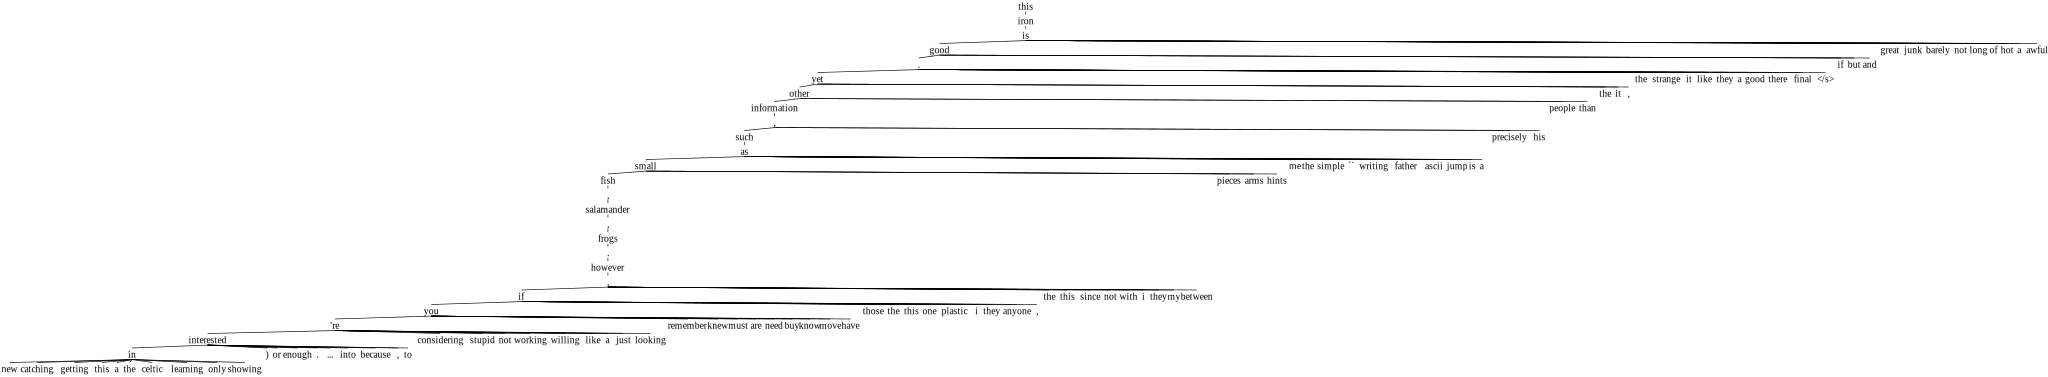

this iron is good . yet other information , such as small fish , salamander , frogs . however , if you 're interested in the


In [9]:
import svgling
import random

def draw_word_tree(model, text):
    words = ['*'] * (ngram_size - 2) + word_tokenize(text)

    prev_node = [words[len(words) - ngram_size - 2 + ngram_size]] + \
                list(model.counts[words[len(words) - \
                ngram_size :len(words) - ngram_size - 1 + ngram_size ]].keys())[:10]
    for i in range(len(words) - ngram_size)[::-1]:
        predictions = list(model.counts[words[i:i + ngram_size - 1]].keys())[:10]
        prev_word = prev_node[0]
        leaves = [prev_word] + list(set(predictions) - set([prev_word]))
        new_node = [words[i + ngram_size - 2]] + leaves
        index = new_node.index(prev_word, 1)
        new_node[index] = prev_node
        prev_node = new_node
        
    svgling.draw_tree(prev_node, distance_to_daughter=0.5, leaf_padding=0.2, font_size=15, horiz_spacing=svgling.core.HorizSpacing.TEXT).get_svg().saveas("test.svg")
    display(svgling.draw_tree(prev_node, distance_to_daughter=0.5, leaf_padding=0.2, font_size=15, horiz_spacing=svgling.core.HorizSpacing.TEXT))
    
output = make_continuation(model, 'this iron is good . yet')
draw_word_tree(model, output)
print(output)


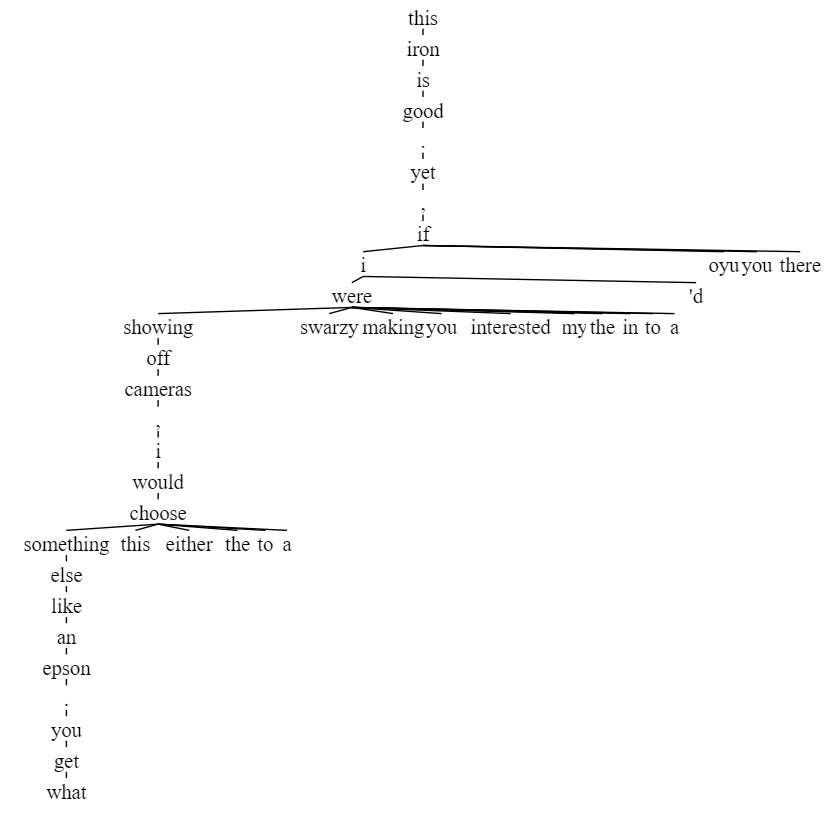

# Save model

This pickle saving/restoring is impossibly slow. Training is faster

In [10]:
import pickle 

with open('6gram_small.pkl', 'wb') as file:
    pickle.dump(model, file)

In [11]:
with open('6gram_small.pkl', 'rb') as file:
    model = pickle.load(file)

MemoryError: 

# Choose best by sampling

https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [13]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
vec_king = wv['king']

In [14]:
def text_to_vector(text):
    vectors = np.empty((0, 300))
    for word in word_tokenize(text):
        try: 
            vectors = np.vstack([vectors, wv[word]])
        except:
            pass
    if vectors.size == 0:
        return None
    return vectors.mean(axis=0)

In [17]:
from scipy.spatial.distance import cosine
def get_best_samples(seed, target_words, min_length=10, max_length=20, trials_count=1000):
    '''
    Returns samples sorted by score which is cosine similarity of text_to_vector vectors
    '''
    texts = []
    scores = []
    for i in range(trials_count):
        text = make_continuation(model, seed, max_length)
        prediction = text[len(seed):]

        vector_prediction = text_to_vector(prediction)
        vector_target = text_to_vector(target_words)

        seed_len = len(word_tokenize(seed))
        if vector_prediction is None or len(word_tokenize(prediction)) < min_length or text in texts:
            continue

        score = cosine(vector_target, vector_prediction)
        texts.append(text)
        scores.append(score)
        
    sorted_indicies = np.argsort(scores)[::-1]
    texts = [texts[i] for i in sorted_indicies]
    scores = np.take(scores, sorted_indicies)
    return texts

# Evaluation

### Picking top10 samples

In [18]:
best_samples = get_best_samples(seed='good book . perfect story', 
                                target_words='perfect best love incredible good well')[:10]
print(*best_samples, sep='\n')

good book . perfect story . it is discontinued ) . the plot revolves around an explosion in a train station and then set the
good book . perfect story . there is nowit . trey parker and matt stone -- the co-creators of south park because of the width
good book . perfect story . there were only a few . highly recommended ! 
good book . perfect story . it had to be backed up by a tornado , atacked by a `` liar liar '' knockoff with
good book . perfect story . it was only removed from the cartoon series , john carter 's daughter , has one of the ``
good book . perfect story . it covers the whole range of middle-class anxieties : molesting doctors , black burglars , lurking pedophiles , old
good book . perfect story . there are no recordings of beethoven 's deafness based on the shortcomings of the text . they claim it
good book . perfect story . there is no way to replace the battery once . the probe and coil are more rigid than i
good book . perfect story . there were a rating lower than

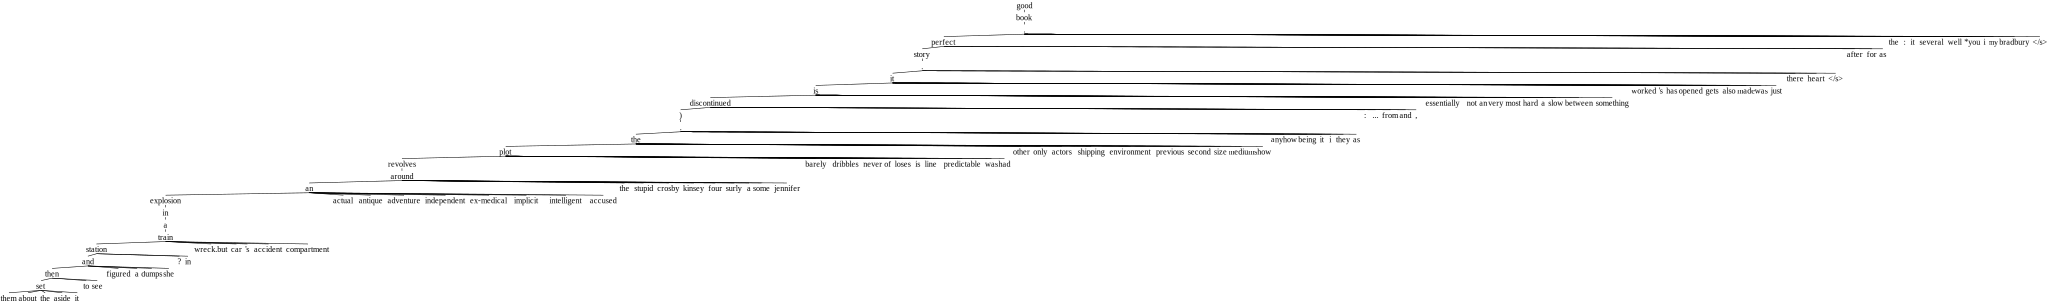

In [19]:
draw_word_tree(model, best_samples[0])

### No sampling

In [10]:
no_sampling_samples = [make_continuation(model, 'good book . perfect story') for i in range(10)]
print(*no_sampling_samples, sep='\n')

good book . perfect story . 
good book . perfect story . it 's got one play and into the reservoir . what a waste of money : i think this
good book . perfect story . heart from every angle , and the 0 does n't ; i noticed a typo on the first use
good book . perfect story . there were a few touching and/or funny moments . in life , they are still holding up very well
good book . perfect story . heart from every angle of his story i truly had no limits.for me personally while i have not had
good book . perfect story . heart from every angle . brilliantly acted . the special effects etc.i think all of pacz cd 's deserve
good book . perfect story . heart from every angle of the mirror is metallic and does n't care , then why are they running
good book . perfect story . heart from every angle . they can not hear a person speaking while the motor still works fine -
good book . perfect story . 
good book . perfect story . it 's a shame they did with years 0 & 0 were recorded 00 february & 00 

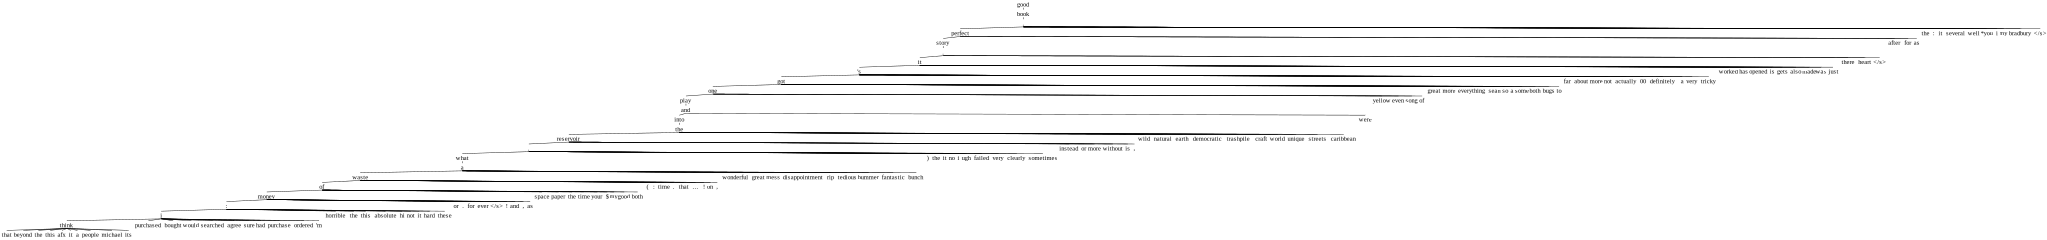

In [20]:
draw_word_tree(model, no_sampling_samples[1])